# Data Visualization

In [11]:
# load packages
import os
import sys
PROJECT_DIR = os.path.abspath(os.path.abspath('') + "/../..")
sys.path.append(PROJECT_DIR)

import numpy as np
import torch as th
import matplotlib.pyplot as plt

from basicts.utils import load_pkl

In [12]:
from basicts.data import SCALER_REGISTRY

## 1. Hyper-Parameter

In [13]:
# hyper-parameter
DATASET_NAME = "PEMS04"
INPUT_LEN = 336
OUTPUT_LEN = 336
MODE = "train"

assert MODE in ["train", "valid", "test"], "error mode"

In [14]:
# file paths
data_file_path = PROJECT_DIR + "/datasets/{0}/data_in{1}_out{2}.pkl".format(DATASET_NAME, INPUT_LEN, OUTPUT_LEN)
index_file_path = PROJECT_DIR + "/datasets/{0}/index_in{1}_out{2}.pkl".format(DATASET_NAME, INPUT_LEN, OUTPUT_LEN)
scaler_file_path = PROJECT_DIR + "/datasets/{0}/scaler_in{1}_out{2}.pkl".format(DATASET_NAME, INPUT_LEN, OUTPUT_LEN)

## 2. Read Data

In [15]:
if_exists = os.path.exists(data_file_path) and os.path.exists(index_file_path) and os.path.exists(scaler_file_path)
err_msg = "Dataset {0} under settings (input_len={1}, output_len={2}) does not exist.".format(DATASET_NAME, INPUT_LEN, OUTPUT_LEN)
tip_msg = "Please run the following command to generate the dataset: python scripts/data_preparation/{0}/generate_training_data.py --history_seq_len {1} --future_seq_len {2}".format(DATASET_NAME, INPUT_LEN, OUTPUT_LEN)

if not if_exists:
    print(err_msg)
    print(tip_msg)
    sys.exit(1)

# load pre-processed data (normalized)
data = load_pkl(data_file_path)["processed_data"]
# load indexes of samples
index = load_pkl(index_file_path)[MODE]
# load scaler
scaler = load_pkl(scaler_file_path)

In [16]:
# data
print("data shape: {0}".format(data.shape))
# index
print("top ten sliding windows: {0}".format(index[:10]))
print("number of sliding windows (i.e., {0} samples): {1}".format(MODE, len(index)))
# scaler
print("scaler information: {0}".format(scaler))
# re-normalize data for visualization
data[:, :, [0]] = SCALER_REGISTRY.get(scaler["func"])(th.Tensor(data[:, :, [0]]), **scaler["args"]).numpy()

data shape: (16992, 307, 3)
top ten sliding windows: [(0, 336, 672), (1, 337, 673), (2, 338, 674), (3, 339, 675), (4, 340, 676), (5, 341, 677), (6, 342, 678), (7, 343, 679), (8, 344, 680), (9, 345, 681)]
number of sliding windows (i.e., train samples): 9793
scaler information: {'func': 're_standard_transform', 'args': {'mean': 207.0614270883184, 'std': 156.44481723685075}}


## 3. Plot Raw Data

In [17]:
def plot_raw_data(data: np.array, selected_node_id: int, begin_time: int = None, end_time: int = None, line_width: float = 1.5, font_size: int = 16, color="green", figure_size: tuple = (10, 5)):
    """plot raw data.

    Args:
        data (np.array): raw data with shape [num_time_slices, num_time_series, num_features].
        selected_node_id (int): selected time series.
        begin_time (int, optional): begin time. Defaults to None.
        end_time (int, optional): end time. Defaults to None.
        line_width (float, optional): line width. Defaults to 1.5.
        font_size (int, optional): font size. Defaults to 16.
        color (str, optional): color. Defaults to "green".
        figure_size (tuple, optional): figure size. Defaults to (10, 5).
    """
    time_span = data.shape[0]
    assert begin_time < end_time, "begin_time should be less than end_time"
    assert begin_time >= 0, "begin_time should be greater than or equal to 0"
    assert end_time <= time_span, "end_time should be less than or equal to {0}".format(time_span)
    plt.rcParams['figure.figsize'] = figure_size
    plot_data = data[begin_time:end_time, selected_node_id, 0]
    plot_index = np.arange(plot_data.shape[0])
    plt.plot(plot_index, plot_data, linewidth=line_width, color=color, label="raw data")
    plt.grid()
    plt.legend(fontsize=font_size)
    plt.show()
    plt.clf()

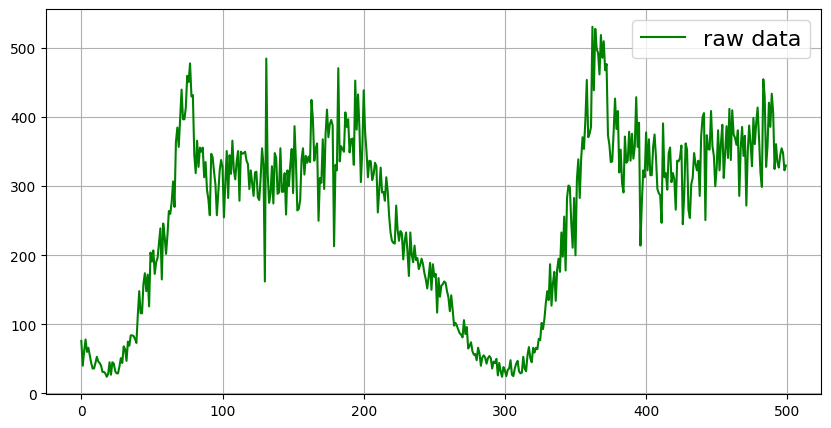

<Figure size 1000x500 with 0 Axes>

In [18]:
plot_raw_data(data=data, selected_node_id=0, begin_time=300, end_time=800, line_width=1.5, font_size=16, color="green", figure_size=(10, 5))

## 4. Plot Samples

In [19]:
def plot_sample(data: np.array, index: list, selected_node_id: int, selected_sample_id: int, line_width: float = 1.5, font_size: int = 16, history_color="blue", future_color="red", figure_size: tuple = (10, 5)):
    """plot a sample.
    
    Args:
        data (np.array): raw data with shape [num_time_slices, num_time_series, num_features].
        index (list): indexes of samples.
        selected_node_id (int): selected time series.
        selected_sample_id (int): selected sample.
        line_width (float, optional): line width. Defaults to 1.5.
        font_size (int, optional): font size. Defaults to 16.
        history_color (str, optional): color of history data. Defaults to "blue".
        future_color (str, optional): color of future data. Defaults to "red".
        figure_size (tuple, optional): figure size. Defaults to (10, 5).
    """
    num_samples = len(index)
    assert selected_sample_id < num_samples, "selected_sample_id should be less than {0}".format(num_samples)
    plt.rcParams['figure.figsize'] = figure_size
    sample_index = index[selected_sample_id]
    plot_history_data = data[sample_index[0]:sample_index[1], selected_node_id, 0]
    plot_future_data = data[sample_index[1]:sample_index[2], selected_node_id, 0]
    plot_history_index = np.arange(sample_index[0], sample_index[1])
    plot_future_index = np.arange(sample_index[1], sample_index[2])
    plt.plot(plot_history_index, plot_history_data, linewidth=line_width, color=history_color, label="history data")
    plt.plot(plot_future_index, plot_future_data, linewidth=line_width, color=future_color, label="future data")
    # lint two parts
    plt.plot([plot_history_index[-1], plot_future_index[0]], [plot_history_data[-1], plot_future_data[0]], linewidth=line_width, color=future_color)
    plt.grid()
    plt.legend(fontsize=font_size)
    plt.show()
    plt.clf()

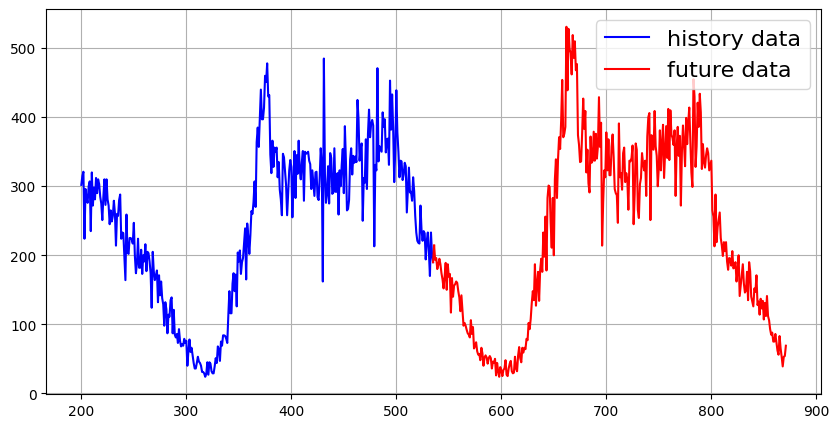

<Figure size 1000x500 with 0 Axes>

In [20]:
plot_sample(data=data, index=index, selected_node_id=0, selected_sample_id=200, line_width=1.5, font_size=16, history_color="blue", future_color="red", figure_size=(10, 5))